In [12]:
import numpy as np
import scipy.fftpack as sfft
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst
import honeycomb as honey
from LatticeInteraction import LattInter
import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import Plotting_Scripts as Plotting
import Fourier_Transforms as Fourier
import Coulomb_Potentials as Potentials
import Reading_Scripts as reading

np.set_printoptions(threshold=np.inf)

#%matplotlib widget

In [13]:
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/BlackP/"


system="BlackP"

NameError: name 'Plot_bandstructure' is not defined

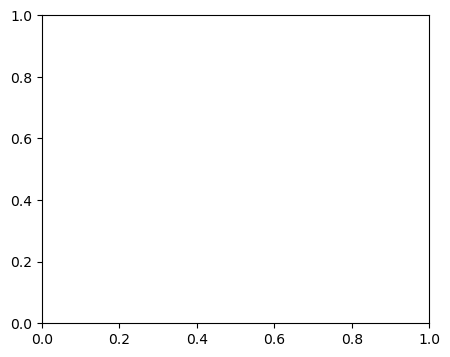

In [14]:
fname="./../../OUT/Band_Structure_out/"+system+"_wann_calc.h5"
fname_new="./../../OUT/Band_Structure_out/"+system+"_New_Ham"+"_wann_calc.h5"

epsk=reading.ReadBands(fname)
epsk_new=reading.ReadBands(fname_new)



klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$"]
fig, ax = plt.subplots(figsize=(5, 4))
#Plot_bandstructure(epsk[:,:],klabel,"black","-",Emin=-100.0,Emax=100.0)
Plot_bandstructure(epsk_new[:,:],klabel,"gray","--",Emin=-100.0,Emax=100.0)
Plot_bandstructure(epsk_new[:,19:21],klabel,"red","-",Emin=-100.0,Emax=100.0)
#Plot_bandstructure(epsk[:,19:21],klabel,"red",Emin=-100.0,Emax=100.0)
ax.set_ylim(-3,3)
#plt.savefig("band_small"+".pdf", bbox_inches="tight", transparent=True)
#plt.savefig("band_small"+".png", bbox_inches="tight", transparent=True)

In [25]:
nkx=48
nky=48
nkz=48


name_Exciton_energy = str(nkx)+'x'+str(nky)+'x'+str(nkz)+'.log'

result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_new/'+name_Exciton_energy, 'E(1)', "1"],capture_output=True,text=True)
E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_Valence    = Energies[:,19]
Energie_Conduction = Energies[:,20]



nkx=48
nky=48
nkz=48

##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"

ψ = Reading.Read_Density(fname)

np.where(ψ[0,:].reshape(nkx,nky,nkz)==np.max(ψ[0,:].reshape(nkx,nky,nkz)))

(array([24]), array([24]), array([24]))

In [26]:
ψ_Exciton_k=np.zeros((1,1,nkx*nky*nkz))
ψ_Exciton_k[0,0,:] = ψ[0,:]

ψ_Exciton_R = Fourier.Transform_r(nkx,nky,nkz,ψ_Exciton_k)

In [27]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


x, y = np.linspace(0, nkx-1, nkx), np.linspace(0, nky-1, nky)
X,Y = np.meshgrid(x,y)
#fig = go.Figure(data=[go.Surface(z=ψ[0,:].reshape(nkx,nky,nkz)[:,:,16], x=x, y=y,
fig = go.Figure(data=[go.Surface(z=ψ[0,:].reshape(nkx,nky,nkz)[:,:,int(nkz/2)], x=x, y=y,
                        colorscale='Reds',cmin=0,cmax=0.6, colorbar = dict(tickfont=dict(
                            color='black',size=30,family='Old Standard TT, serif',),orientation='h')   )])
#fig = ff.create_trisurf(z=ψ[0,:].reshape(32,32,32)[:,:,16], x=X, y=Y)

fig.update_layout(scene = dict(
                    xaxis = dict( title = ' ',
                        ticktext= [r'-1/4',r'0',r'1/4'],
                        tickvals= [int(nkx/2)-int(nkx/4),int(nkx/2)-1,int(nkx/2)+int(nkx/4)-1],
                        range=[int(nkx/2)-int(nkx/4)-1,int(nkx/2)+int(nkx/4)],tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',)),
                    yaxis = dict( title = ' ',
                        ticktext= [r'-1/4',r'0',r'1/4'],
                        tickvals= [int(nky/2)-int(nky/4),int(nky/2)-1,int(nky/2)+int(nky/4)-1],
                        range=[int(nky/2)-int(nky/4)-1,int(nky/2)+int(nky/4)],tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',)) ,
                    zaxis = dict( title = ' ',
                            tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',) )),
                    width=700,
                    margin=dict(r=10, l=10, b=10, t=10)
                  )


#fig.update_xaxes(range=[8, 23])
#fig.update_layout(xaxis = dict(range=[7,24]))
#fig.update_yaxes(range=[8, 23])


fig.show()

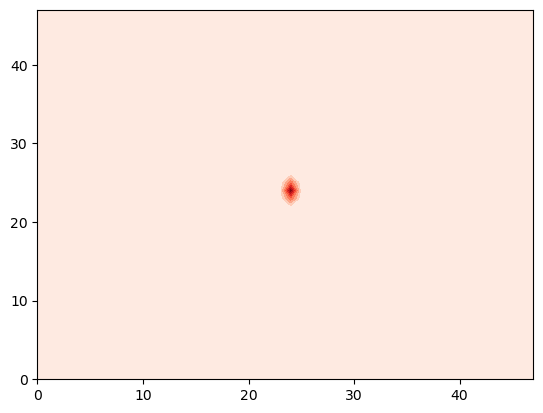

In [28]:
fig, ax = plt.subplots(1, 1)
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
#levels = np.arange(0.0,0.6, 0.01)
#levels[0] = 1e-3
#norm = colors.BoundaryNorm(levels, ncolors=palette.N)


#contour = ax.imshow(ψ[0,:].reshape(32,32,32)[:,:,16],aspect='auto', cmap=palette,norm=norm)
contour = ax.contourf(ψ[0,:].reshape(nkx,nky,nkz)[:,:,int(nkz/2)], cmap=palette)
#cbar = fig.colorbar(contour, extend='min', shrink=0.9, ax=ax)


In [29]:
name_lat = path+'Lattice'
orbitales,parameters = Reading.ReadLattice(name_lat+'.h5')

a = parameters[0] / cst.aB
b = parameters[1] / cst.aB
c = parameters[2] / cst.aB


lat = np.zeros([3,3])
lat[0,:] =  np.array([a,  0.0, 0.0])
lat[1,:] =  np.array([0.0,  b, 0.0])
lat[2,:] =  np.array([0.0, 0.0,  c])

a1, a2, a3 = lat[0,:], lat[1,:], lat[2,:]

In [30]:
first_x   = np.arange(0,int(nkx/2)+1,1,dtype=int)
second_x  = np.arange(-int(nkx/2)+1,0,1,dtype=int)

first_y   = np.arange(0,int(nky/2)+1,1,dtype=int)
second_y  = np.arange(-int(nky/2)+1,0,1,dtype=int)

first_z   = np.arange(0,int(nkz/2)+1,1,dtype=int)
second_z  = np.arange(-int(nkz/2)+1,0,1,dtype=int)

total_x = np.array( list(first_x) + list(second_x))
total_y = np.array( list(first_y) + list(second_y))
total_z = np.array( list(first_z) + list(second_z))

irvec = np.zeros( (len(total_x)*len(total_y)*len(total_z),3),dtype=int )

contador=0
for kk in range(0,len(total_z)):
    for jj in range(0,len(total_y)):
        for ii in range(0,len(total_x)):

            irvec[contador,0] = total_x[ii]
            irvec[contador,1] = total_y[jj]
            irvec[contador,2] = total_z[kk]
            contador+=1

xs = irvec[:,0]
ys = irvec[:,1]
zs = irvec[:,2]

rvecs = xs[:,None] * a1[None,:] + ys[:,None] * a2[None,:]+ zs[:,None] * a3[None,:]


p_ex = np.array([0.0,0.0,0.0])

In [31]:
p_dot_R = np.einsum('ri,i->r', rvecs, p_ex)

In [32]:
gR = np.zeros_like(ψ_Exciton_R)
gR[0,0,:] = ψ_Exciton_R[0,0,:]*np.exp(-1.0j*p_dot_R)

ψ_Exciton_k_plus_p = np.zeros_like(ψ_Exciton_k)

ψ_Exciton_k_plus_p = Fourier.Transform_q(nkx,nky,nkz,gR)

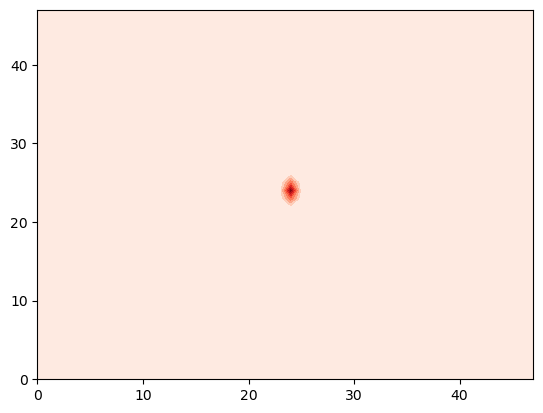

In [33]:
fig, ax = plt.subplots(1, 1)
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
#levels = np.arange(0.0,0.6, 0.01)
#levels[0] = 1e-3
#norm = colors.BoundaryNorm(levels, ncolors=palette.N)


#contour = ax.imshow(ψ[0,:].reshape(32,32,32)[:,:,16],aspect='auto', cmap=palette,norm=norm)
contour = ax.contourf(abs(ψ_Exciton_k_plus_p[0,0,:].reshape(nkx,nky,nkz)[:,:,int(nkz/2)]), cmap=palette)
#cbar = fig.colorbar(contour, extend='min', shrink=0.9, ax=ax)


In [34]:
# Approximate the delta function
"""eps = 0.1
def delta(x):
    return (1/pi)*(eps/(x**2 + eps**2))
"""
def Delta (E,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*E**2/sigma**2)

In [35]:
EnergySpectrum = np.linspace(np.min(Energie_Valence)+0.4943417/cst.Ry,np.max(Energie_Valence)+0.4943417/cst.Ry,40)

Photo = np.zeros((len(EnergySpectrum),np.shape(ψ_Exciton_k_plus_p)[-1]))

tolerancia = 0.01


for energia_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(ψ_Exciton_k_plus_p)[-1]):
        if abs(EnergySpectrum[energia_ii]-Energie_Valence[kk]-0.4943417/cst.Ry)<= tolerancia:
            Photo[energia_ii,kk] = Delta( EnergySpectrum[energia_ii]-Energie_Valence[kk]-0.4943417/cst.Ry, tolerancia) * abs(ψ_Exciton_k_plus_p[0,0,kk])



/tmp/ipykernel_10591/929303922.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



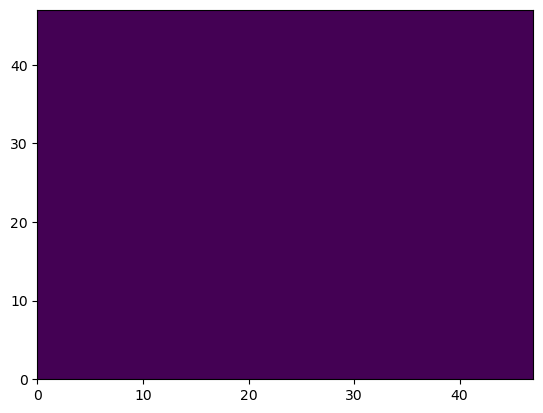

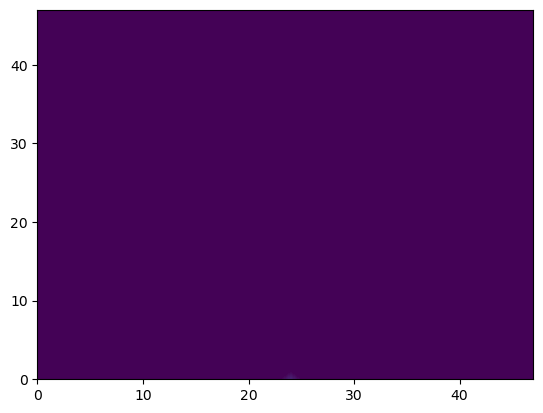

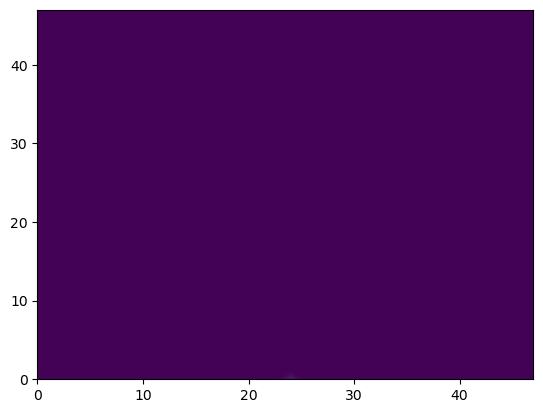

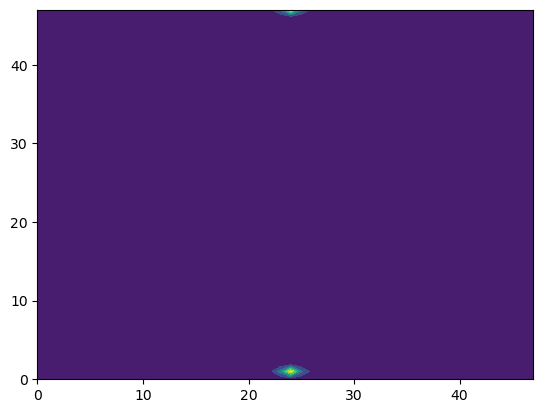

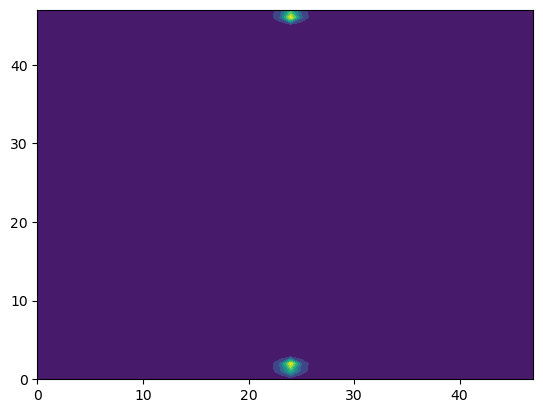

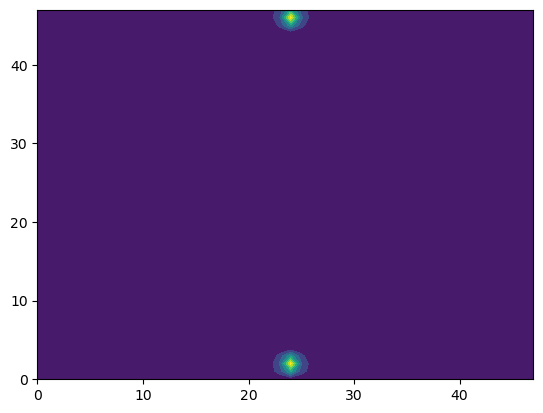

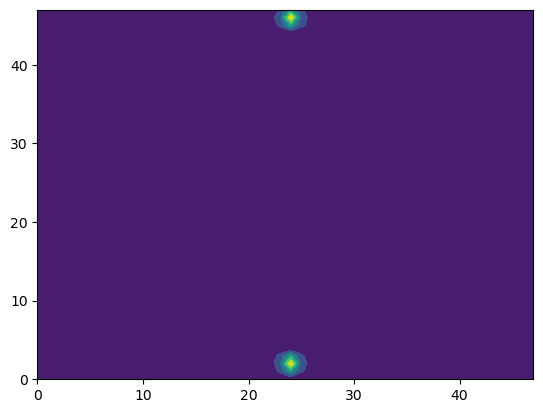

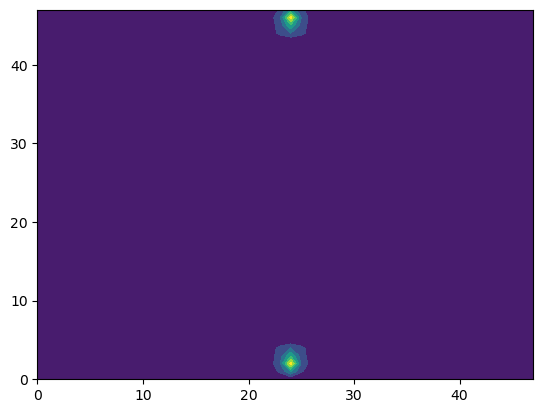

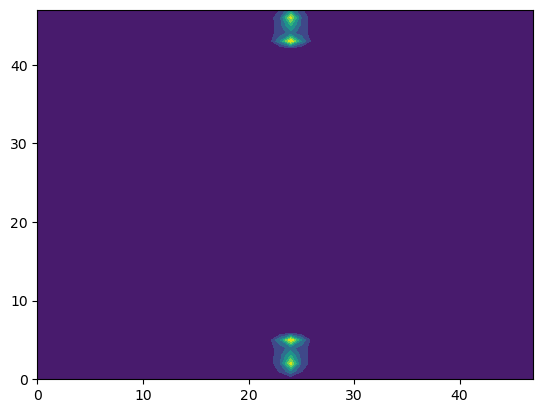

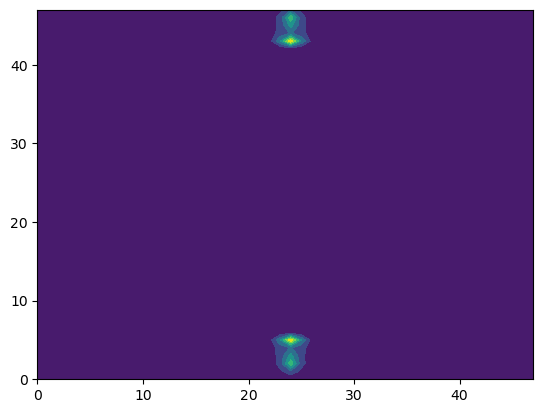

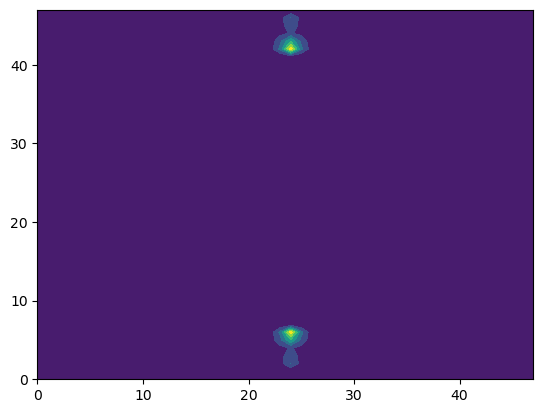

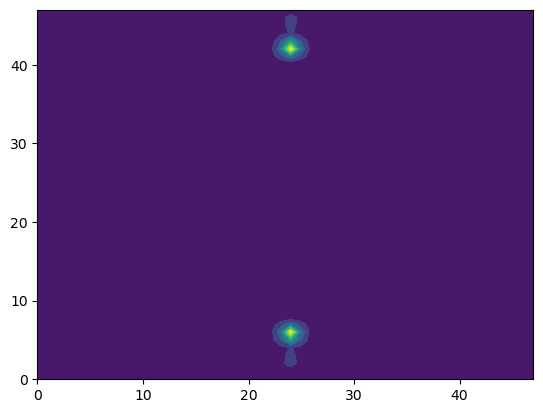

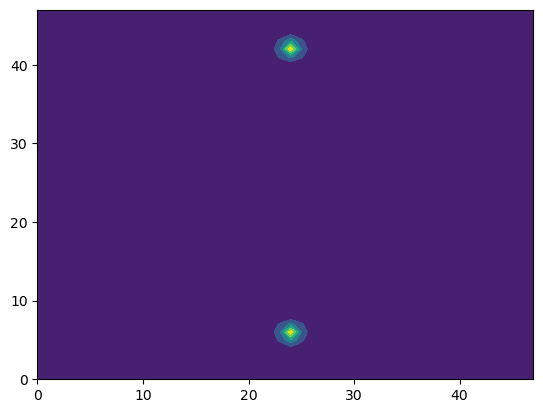

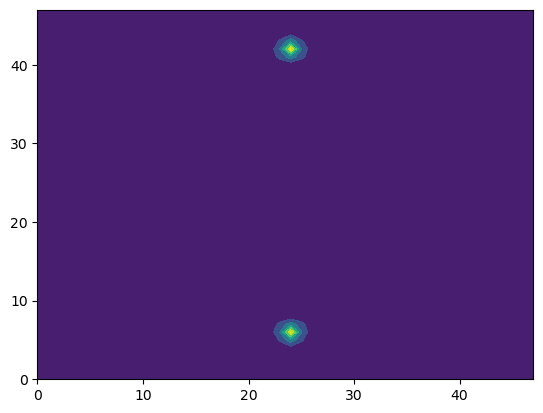

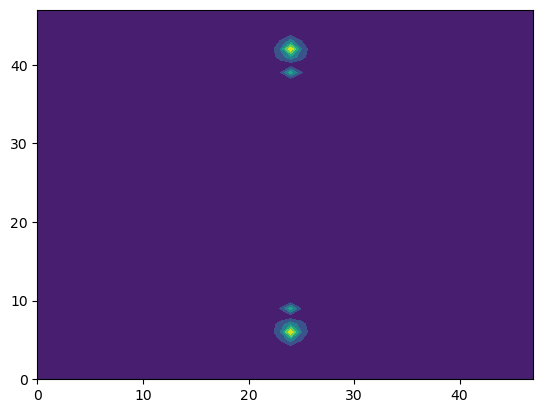

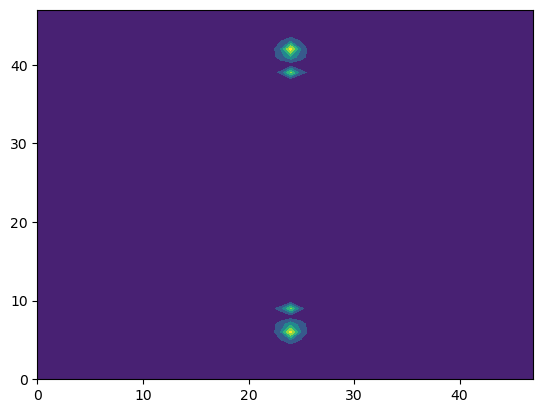

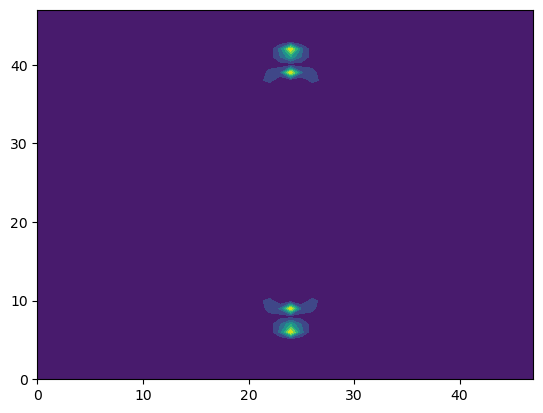

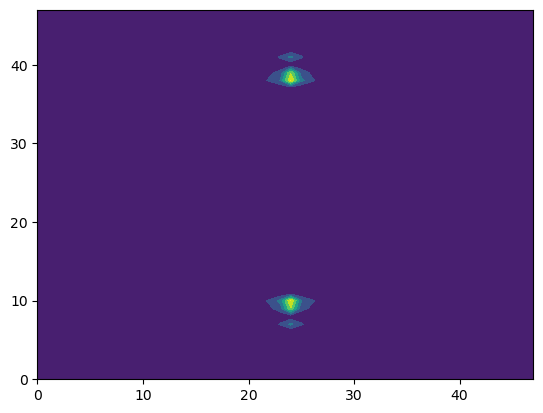

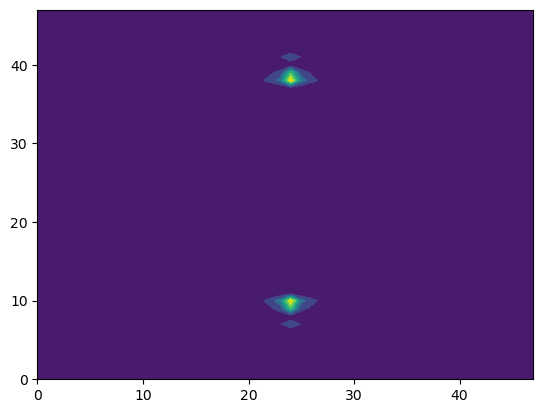

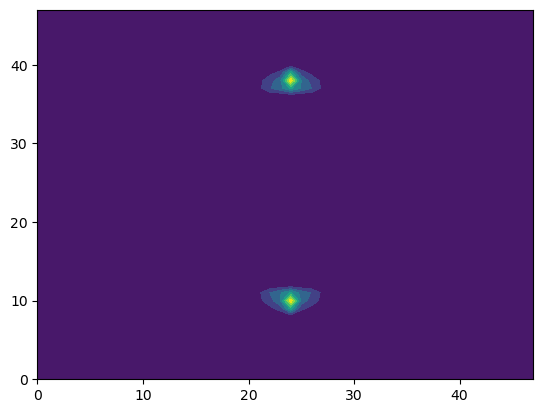

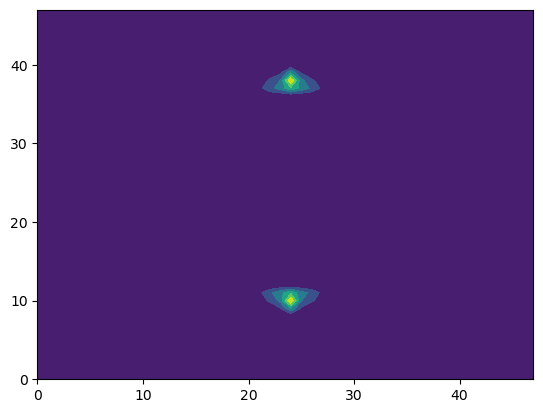

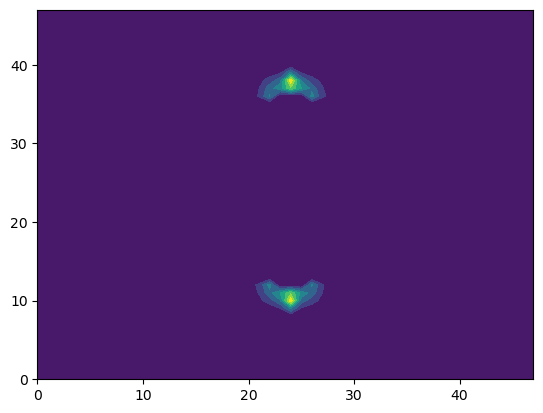

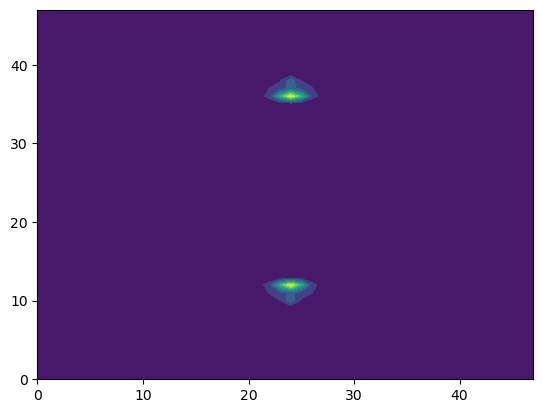

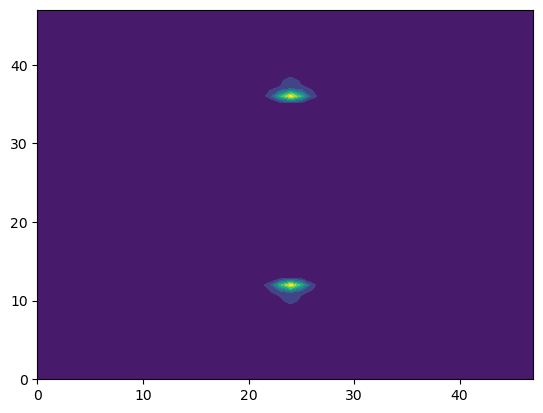

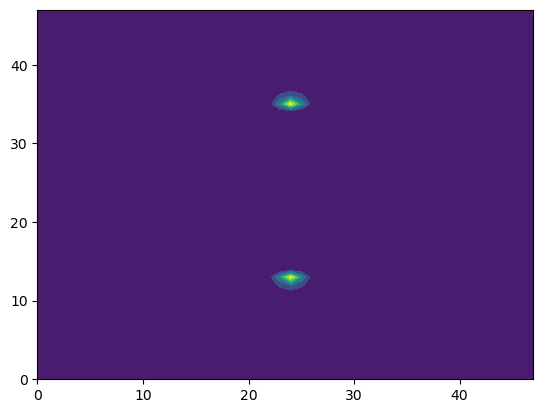

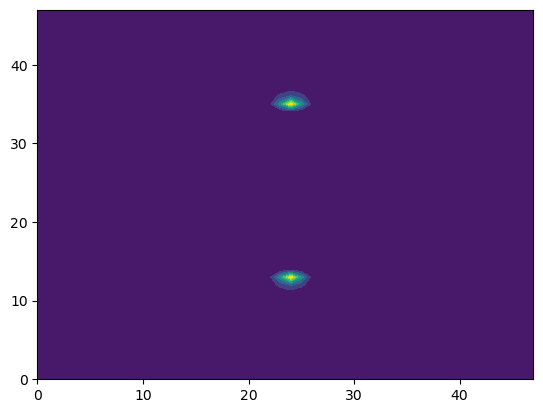

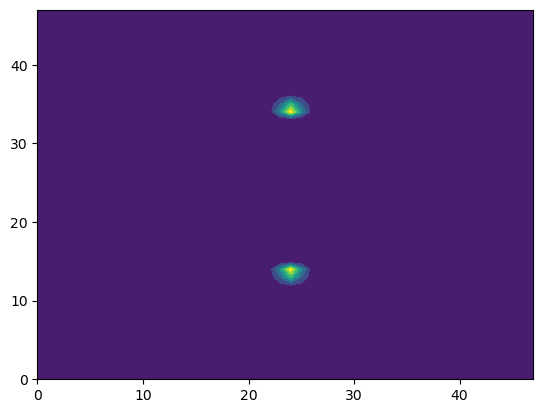

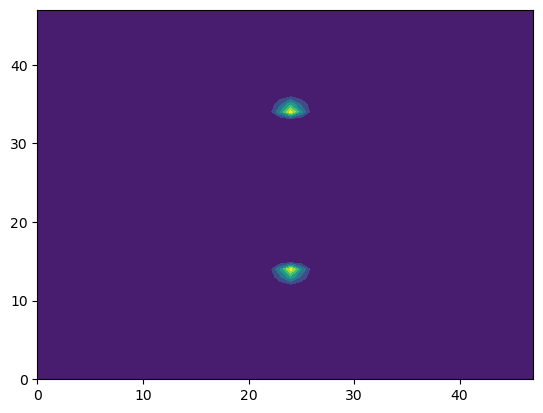

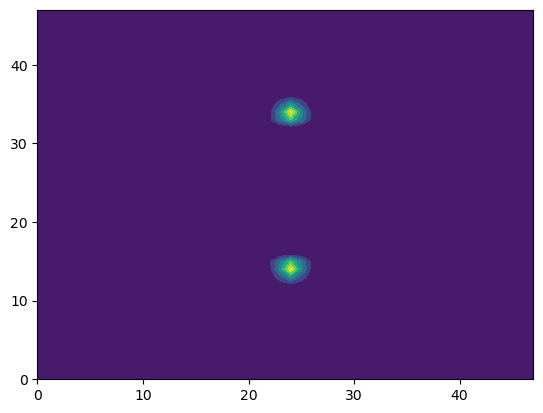

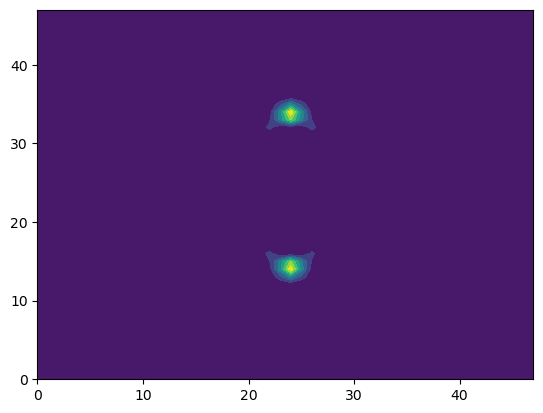

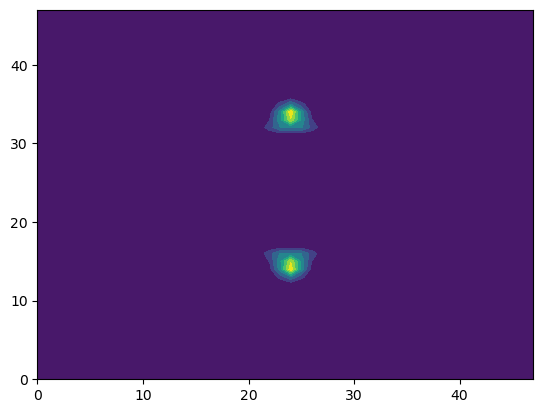

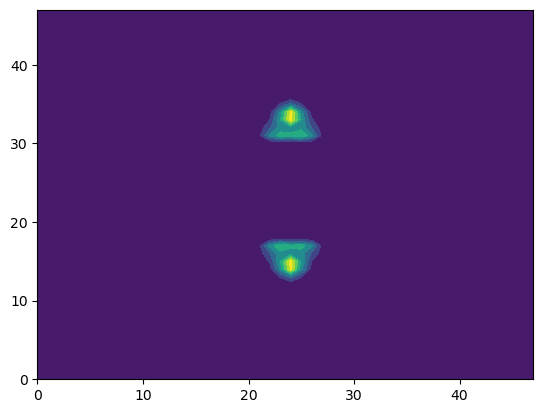

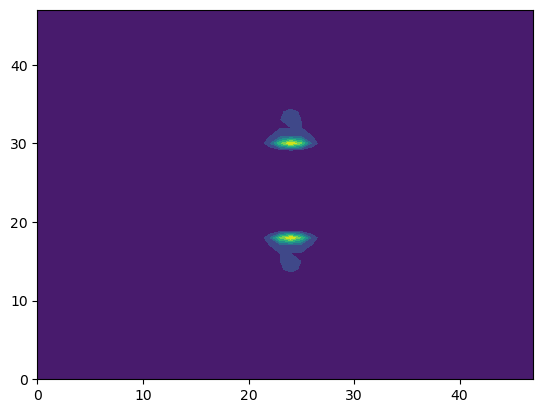

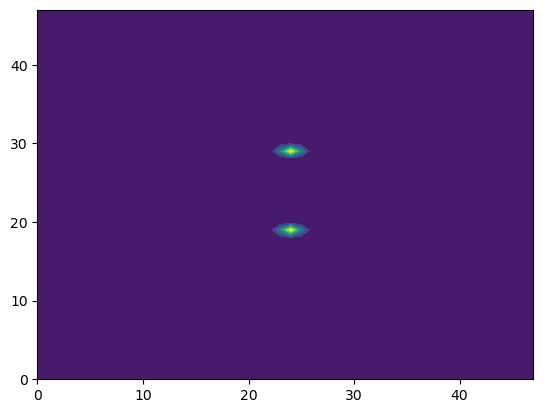

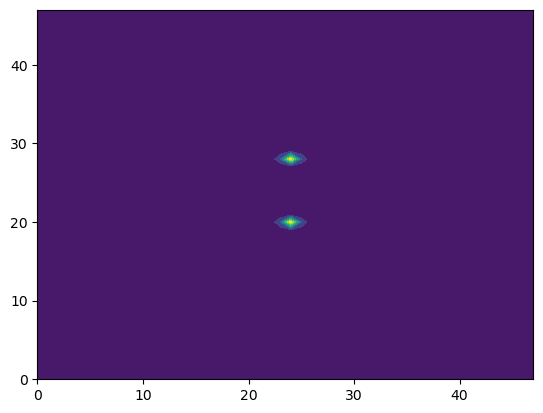

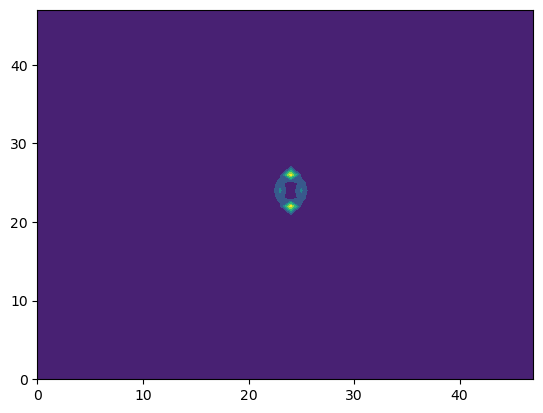

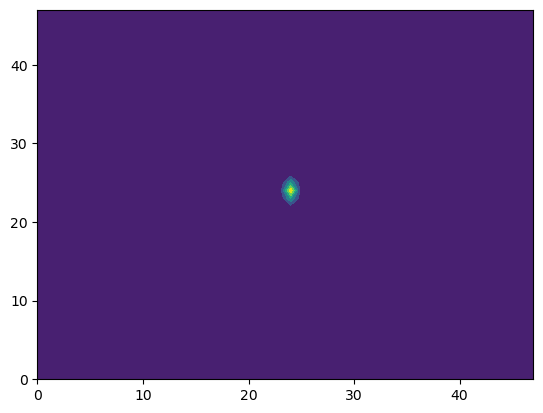

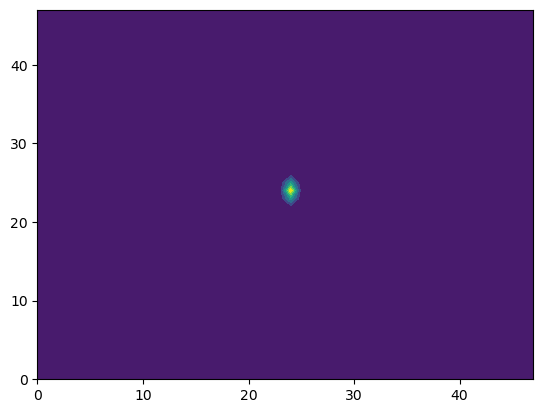

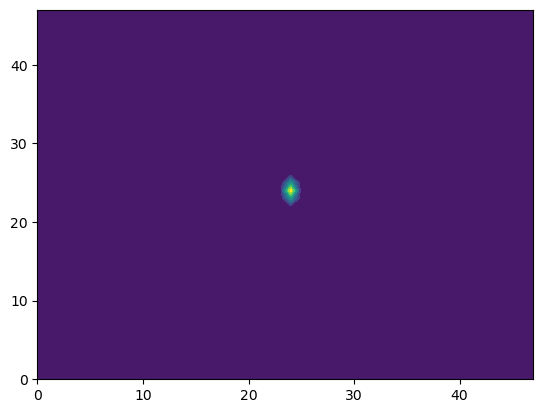

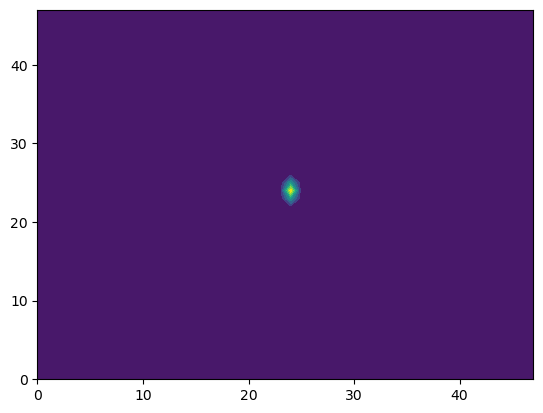

In [36]:
#levels = np.arange(0.0,0.6, 0.01)
#levels[0] = 1e-3
#norm = colors.BoundaryNorm(levels, ncolors=palette.N)

palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
levels = np.arange(np.min(Photo[:,:]),np.max(Photo[:,:]), 0.1)
levels[0] = 1e-3
norm = colors.BoundaryNorm(levels, ncolors=palette.N)



for i in range(0,40):
    fig, ax = plt.subplots(1, 1)
    palette = copy(plt.get_cmap('Reds'))
    palette.set_under('white', 1.0)  # 1.0 represents not transparent
    #levels = np.arange(0.0,0.6, 0.01)
    #levels[0] = 1e-3
    #norm = colors.BoundaryNorm(levels, ncolors=palette.N)

    #contour = ax.imshow(ψ[0,:].reshape(32,32,32)[:,:,16],aspect='auto', cmap=palette,norm=norm)
    contour = ax.contourf(Photo[i,:].reshape(nkx,nky,nkz)[:,:,int(nkz/2)],
                          vmin=np.min(Photo[i,:]), vmax=np.max(Photo[i,:]))
    #cbar = fig.colorbar(contour, extend='min', shrink=0.9, ax=ax)

In [9]:
(np.min(Energie_Conduction) - np.max(Energie_Valence))*27

0.50248904773909

In [10]:
np.min(Energie_Valence)
np.max(Energie_Valence)

-0.017550601142684374